# Visual Question Answering (Classification)

In [1]:
import os
print(os.listdir("/kaggle/input"))

['processed-daquar-dataset']


In [2]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value = user_secrets.get_secret("WANDB_API_KEY")


# Login to W&B
wandb.login(key=secret_value)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
from copy import deepcopy #unlike shallow copy deep copy duplicates even the nested objects, which is useful when we need an entirely independent copy of a data structure
from dataclasses import dataclass #dataclass is a decorater that generates special methods (eg, __int__, __repr__) for classes, making it easier to handle data structures with less boiler plate
from typing import Dict, List, Optional, Tuple, Union
from datasets import load_dataset
import numpy as np

In [4]:
import torch
import torch.nn as nn
# AutoModel: Loads a pre-trained model.
# AutoFeatureExtractor: Extracts features (usually embeddings) from raw data.
# AutoTokenizer: Tokenizes text data for input to transformer models.

from transformers import AutoModel, AutoFeatureExtractor, AutoTokenizer
from transformers import ViTImageProcessor as ViTFeatureExtractor
from transformers import TrainingArguments, Trainer
from transformers import logging

In [5]:
import nltk
from nltk.corpus import wordnet
import ssl
import zipfile

# Set up SSL context for downloading
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Define paths
nltk_data_dir = '/kaggle/working/nltk_data'
zip_file_path = f'{nltk_data_dir}/corpora/wordnet.zip'
extract_dir = f'{nltk_data_dir}/corpora/'

# Download WordNet data
nltk.download('wordnet', download_dir=nltk_data_dir)
nltk.data.path.append(nltk_data_dir)

# Unzip the WordNet data
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Verify WordNet data
try:
    nltk.data.find('corpora/wordnet')
    print('WordNet found after extraction')
except LookupError:
    print('WordNet still not found after extraction')


[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...
WordNet found after extraction


In [6]:
os.environ["OMP_NUM_THREADS"] = "1"
# SET CACHE FOR HUGGINGFACE TRANSFORMERS + DATASETS
os.environ['HF_HOME'] = os.path.join(".", "cache")
# SET ONLY 1 GPU DEVICE
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
# Set logging level to error
logging.set_verbosity_error()

In [7]:
# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# Check if PyTorch recognizes the GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Additional info if CUDA is available
if device.type == 'cuda':
    print("GPU:", torch.cuda.get_device_name(0))
    print("CUDA Version:", torch.version.cuda)

CUDA available: True
Device: cuda:0
GPU: Tesla P100-PCIE-16GB
CUDA Version: 12.3


In [8]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Load the full dataset from the CSV file
full_data_path = "/kaggle/input/processed-daquar-dataset/data.csv"  # Correct path without single quotes
full_dataset = pd.read_csv(full_data_path)

# Perform a random split without stratification (80% train, 20% test)
train_data, test_data = train_test_split(full_dataset, test_size=0.2)

# Create an output directory for saving the split files if it doesn't exist
output_dir = "/kaggle/working/daquer-dataset"
os.makedirs(output_dir, exist_ok=True)

# Save the split data into separate files
train_data_path = os.path.join(output_dir, "data_train.csv")
test_data_path = os.path.join(output_dir, "data_eval.csv")
train_data.to_csv(train_data_path, index=False)
test_data.to_csv(test_data_path, index=False)

# Print the split sizes to confirm
print("Training set size:", len(train_data))
print("Test set size:", len(test_data))

Training set size: 9974
Test set size: 2494


## Loading the Dataset with load_dataset
- load_dataset: This function from the Hugging Face datasets library loads a dataset from a specified format (csv here) and expects paths to the files.
- Parameters:
    - "csv": Specifies that the files are in CSV format.
    - data_files: Provides a dictionary where the keys ("train" and "test") define dataset splits, and the values are paths to the respective CSV files.
- Dataset Structure: After this, dataset will contain two splits:
    - dataset["train"]: Points to the training dataset loaded from data_train.csv.
    - dataset["test"]: Points to the testing dataset loaded from data_eval.csv.
- Path Construction: os.path.join is used to construct paths in a cross-platform way, using ".." to go up one directory level.

In [9]:
# Load the dataset using the train and test files
dataset = load_dataset("csv", data_files={
    "train": train_data_path,
    "test": test_data_path
})

# Check if the train and test files exist
print("Train file exists:", os.path.exists(train_data_path))
print("Test file exists:", os.path.exists(test_data_path))

# Path to the answer space file
answer_space_path = os.path.join("/kaggle/input/processed-daquar-dataset", "answer_space.txt")

# Check if answer space file exists and read it
if os.path.exists(answer_space_path):
    with open(answer_space_path) as f:
        answer_space = f.read().splitlines()
else:
    raise FileNotFoundError(f"{answer_space_path} not found. Ensure the answer space file is in the correct directory.")

# Map answers to labels based on the answer space
dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0])  # Select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)

# Print the final dataset structure
print(dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Train file exists: True
Test file exists: True


Map:   0%|          | 0/9974 [00:00<?, ? examples/s]

Map:   0%|          | 0/2494 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 9974
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 2494
    })
})


1. The code first loads an "answer space" file that contains a list of all possible answers. This list assigns each answer a unique numeric index.
2. It then applies a transformation using dataset.map to process the answer column:
    - For each answer, it standardizes the text (removes spaces and takes the first answer if there are multiple answers).
    - It maps this answer to an index (label) based on its position in answer_space.
3. The result is a label column that contains a numeric value representing each answer, making the dataset ready for model training.

## Display a random example

In [10]:
from IPython.display import display
from PIL import Image

def showExample(train=True, id=None):
    # Select the dataset split based on the 'train' parameter
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
        
    # If no specific ID is provided, choose a random one
    if id is None:
        id = np.random.randint(len(data))
    
    # Define the image path based on the previous setup
    image_path = os.path.join("/kaggle/input/processed-daquar-dataset", "images", data[id]["image_id"] + ".png")
    
    # Load and display the image
    image = Image.open(image_path)
    display(image)

    # Print the question and answer along with the label
    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], "(Label: {0})".format(data[id]["label"]))

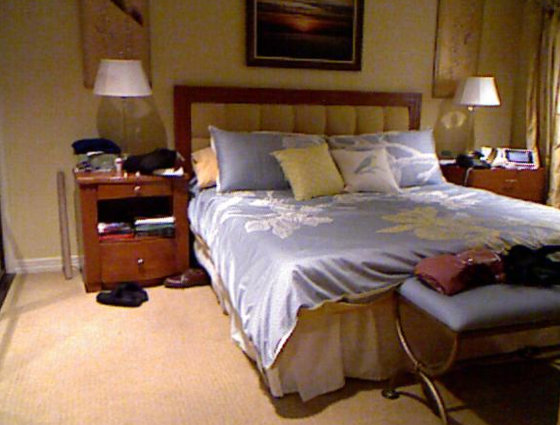

Question:	 what are stuck on the wall
Answer:		 photo (Label: 377)


In [11]:
showExample()

## Multimodal Collator

Define a class called MultimodalCollator, which is responsible for preparing and collating data for a multimodal model. Let's go through the concept of multimodal data and collators.

### Key Concepts
#### Multimodal:
Multimodal data refers to data that includes multiple types of information. In this case, it includes both text (the question) and images (the image related to the question).
- Multimodal models are designed to handle and process different modalities (like text, images, and audio) simultaneously, allowing the model to capture richer, more comprehensive information from diverse sources. 
- For instance, visual question answering (VQA) is a task where the model processes both images and text to provide answers.

#### Collator:
In machine learning and NLP, a collator is a function or class that helps prepare and structure data batches for model training or inference. Specifically, it handles tasks like: Tokenizing text, Processing images, Combining different data types into a single batch with consistent tensor sizes
- Collators are particularly useful in multimodal settings, where data comes in multiple formats, requiring specific processing steps for each modality.

#### Purpose of Multimodal Collator
The MultimodalCollator class in this code is designed to:
- Tokenize and process text data using a tokenizer.
- Preprocess and prepare image data using a preprocessor.
- Combine (or "collate") the processed text and image data into a structured batch that can be passed into a multimodal model for training or evaluation.

In [12]:
# The @dataclass decorater simplifies the creation of classes by automatically adding special methods like __init__.
# Here this decorater is initializing the tokenizer and preprocessor
from typing import Any


@dataclass
class MultimodalCollator:
    tokenizer : AutoTokenizer # An instance of AutoTokenizer for tokenizing text.
    preprocessor : AutoFeatureExtractor # An instance of AutoFeatureExtractor which preprocesses image data into the correct format.

    def tokenize_text(self, texts : List[str]) -> Dict[str, torch.Tensor]:
        """
        @brief : Tokenize a list of text strings into input tensors for a transformer model.
                 This function converts each texts into token IDs, token type IDs, and attention masks,
                 suitable for input to transformer model such as BERT, DistilBERT, etc.
        
        @param : text (List[str]) - A list of text strings (questions or sentensces) to be tokenized.
                                    Each entry in the list represents a single text inputs.

        @return : Dict[str, torch.Tensor] - A dicitionary with 3 keys.
                                            "input_ids" : Tensor containing the tokenIds of each texts, with padding to the longest text in the batch.
                                            "token_type_ids" : Tensor containing type IDs to differentiate between segments (useful for tasks involving two sequences).
                                            "attention_mask": Tensor indicating which tokens are actual content (1) and which are padding (0).
        """
        encoded_text = self.tokenizer(
            text = texts,
            padding = 'longest',
            max_length = 24,
            truncation = True,
            return_tensors = 'pt',
            return_token_type_ids = True,
            return_attention_mask = True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }
    
    def preprocess_images(self, images: List[str]) -> Dict[str, torch.Tensor]:
        """
        @brief : Preprocess a list of image IDs by loading the image, converting them to RGB, 
                 and transforming them into tensors suitable for model input. This function is
                 designed for multimodal models that requires image data alongside other modalities.

        @params : images (List[str]) - A list of image IDs (strings) used to locate and load images from disk.
                            Each entry in the list represents an image ID, which will be combined with a file path to locate the image file.

        @return : Dict[str, torch.Tensor] - A dictionary with one key:
                            pixel_values": A tensor containing the processed image data with RGB channels, 
                            ready for input to a model. The images are processed to have consistent
                            shapes and normalized values according to the model's requirements.        
        """
        processed_images = self.preprocessor(
            images = [Image.open(os.path.join("/kaggle/input/processed-daquar-dataset", "images", image_id + ".png")).convert('RGB') for image_id in images],
            return_tensors = "pt",
        )
        return{
            "pixel_values" : processed_images['pixel_values'].squeeze(),
        }
    
    def __call__(self, raw_batch_dict: Union[Dict, List[Dict]]) -> Dict[str, torch.Tensor]:
        """
        @brief : Processes a batch of raw data by tokenizing text, preprocessing images, 
            and collating the data into a format suitable for model input. This function 
            combines text and image data for multimodal models that require both inputs 
            in a single batch. It handles both individual examples (dict) and batches (list of dicts).

        @params : raw_batch_dict (Union[Dict, List[Dict]]): The raw batch of data to process.
                - If `raw_batch_dict` is a dictionary, it represents a single example with keys:
                    - "question": The question text as a string.
                    - "image_id": The image identifier as a string.
                    - "label": The label as an integer.
                - If `raw_batch_dict` is a list of dictionaries, each dictionary represents an example
                with the same keys as described above.

        @return
            Dict[str, torch.Tensor]: A dictionary containing processed tensors for the batch, with keys:
                - "input_ids": Tensor containing the token IDs for the text questions.
                - "token_type_ids": Tensor containing type IDs for the text (useful for paired text inputs).
                - "attention_mask": Tensor indicating which tokens are actual content and which are padding.
                - "pixel_values": Tensor containing the processed image data for model input.
                - "labels": Tensor containing the labels for each example, converted to `torch.int64` dtype.

        @example
            Given a batch of examples in `raw_batch_dict`:
            [
                {"question": "What is in the picture?", "image_id": "image1", "label": 0},
                {"question": "Who is in the picture?", "image_id": "image2", "label": 1}
            ]
            This function will return a dictionary with processed tensors for "input_ids", "token_type_ids", 
            "attention_mask", "pixel_values", and "labels" ready for model input.
        """
    
        return {
            **self.tokenize_text(
                raw_batch_dict['question']
                if isinstance(raw_batch_dict, dict) else
                [i['question'] for i in raw_batch_dict]
            ), 
            **self.preprocess_images(
                raw_batch_dict['image_id']
                if isinstance(raw_batch_dict, dict) else
                [i['image_id'] for i in raw_batch_dict]
            ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }

## Multimodal VQA Model Architecture
The MultimodalVQAModel class is a custom neural network model built for Visual Question Answering (VQA) tasks. This model processes both text (questions) and images, fuses their representations, and then classifies the combined representation into one of the predefined answer categories.

In [13]:
class MultimodalVQAModel(nn.Module):
    def __init__(self, num_labels: int = len(answer_space),intermediate_dim: int = 512,
        pretrained_text_name: str = 'bert-base-uncased',
        pretrained_image_name: str = 'google/vit-base-patch16-224-in21k'):
        """
        @brief
            Initializes the multimodal model by setting up encoders for text and images,
            a fusion layer, classifier, and the loss function.

        @params
            num_labels (int): Number of output labels for classification.
            intermediate_dim (int): Hidden layer size for the fusion layer.
            pretrained_text_name (str): Name of the pre-trained text model.
            pretrained_image_name (str): Name of the pre-trained image model.

        @return
            None
        """
        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name
        
        # Initialize two pre-trained models from the Hugging Face transformers library:
            # text_encoder: A pre-trained text encoder for question processing.
            # image_encoder: A pre-trained image encoder for processing visual information.
        self.text_encoder = AutoModel.from_pretrained(
            self.pretrained_text_name,
        )
        self.image_encoder = AutoModel.from_pretrained(
            self.pretrained_image_name,
        )
        # Defines a fusion layer, which takes the combined features from both the text and image encoders, 
        # reduces their dimensionality, and applies ReLU activation and dropout for regularization.
        # nn.Linear: A fully connected layer that takes the concatenated hidden sizes of both encoders as input and outputs intermediate_dim units.
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        # Defines a linear classifier that maps the fused output to the number of possible answers (num_labels).
        self.classifier = nn.Linear(intermediate_dim, self.num_labels)
        # Sets up the loss function for training. Here, CrossEntropyLoss is used, which is standard for classification tasks.
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, input_ids: torch.LongTensor, pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):
        """
        @brief
            Defines the forward pass for the multimodal VQA model, including text and image encoding,
            feature fusion, classification, and optional loss calculation.

        @params
            input_ids (torch.LongTensor): Token IDs for the text (question) input.
            pixel_values (torch.FloatTensor): Image data in tensor format.
            attention_mask (Optional[torch.LongTensor]): Attention mask for text input.
            token_type_ids (Optional[torch.LongTensor]): Token type IDs for segmenting text input.
            labels (Optional[torch.LongTensor]): True labels for the data, used for calculating loss.

        @return
            Dict[str, torch.Tensor]: Dictionary with:
                - "logits": Classification logits for each answer class.
                - "loss": Cross-entropy loss if labels are provided.
        """
        # Passes the tokenized text through the text_encoder, 
        # which outputs a dictionary including the pooler_output (text representation)
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        # Passes the processed image data through the image_encoder, 
        # which outputs a dictionary including the pooler_output (image representation).
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        # Fusion:
            # Concatenates encoded_text['pooler_output'] and encoded_image['pooler_output'] along dim=1 to combine text and image features.
            # Passes the combined features through the fusion layer.
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )       
        # Classification:
        # Passes the fused output through the classifier to produce logits, 
        # which represent predicted scores for each answer class
        # In classification tasks, logits represent the scores for each class and are used to calculate the final class probabilities.
        logits = self.classifier(fused_output)
        

        # If labels are provided, computes the cross-entropy loss and adds it to the output dictionary
        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss
        
        return out

## Function to Create the Multimodal VQA Models along with their Collators

In [14]:
def createMultimodalVQACollatorAndModel(
    text: str = 'bert-base-uncased',
    image: str = 'google/vit-base-patch16-224-in21k') -> Tuple[MultimodalCollator, MultimodalVQAModel]:
    """
    @brief
        Initializes and returns a collator and a multimodal VQA model. The collator
        prepares text and image data in batches for model input, while the model combines
        both modalities to predict an answer.

    @params
        text (str): The name of the pre-trained text model (e.g., 'bert-base-uncased') 
                    for question encoding. Default is 'bert-base-uncased'.
        image (str): The name of the pre-trained image model (e.g., 'google/vit-base-patch16-224-in21k') 
                     for image feature extraction. Default is 'google/vit-base-patch16-224-in21k'.

    @return
        Tuple[MultimodalCollator, MultimodalVQAModel]: A tuple containing:
            - `multi_collator` (MultimodalCollator): An instance of MultimodalCollator that uses
              the specified tokenizer and image preprocessor to format text and image data.
            - `multi_model` (MultimodalVQAModel): An instance of MultimodalVQAModel, initialized
              with the specified pre-trained text and image models, ready to perform multimodal
              VQA tasks.

    @example
        collator, model = createMultimodalVQACollatorAndModel(
            text='bert-base-uncased', 
            image='google/vit-base-patch16-224-in21k'
        )
    """
    
    # Initialize tokenizer and image preprocessor based on specified models
    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = ViTFeatureExtractor.from_pretrained(image)
#     preprocessor = AutoFeatureExtractor.from_pretrained(image)

    # Create the MultimodalCollator with the initialized tokenizer and preprocessor
    multi_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )

    # Initialize the MultimodalVQAModel with the specified text and image model names
    multi_model = MultimodalVQAModel(pretrained_text_name=text, pretrained_image_name=image).to(device)
    
    # Return both the collator and model for data preparation and training
    return multi_collator, multi_model


## Performance Metrics

The wup_measure function calculates the Wu-Palmer (WUP) similarity score between two words. This score is a semantic similarity measure, specifically designed for words within a hierarchical taxonomy (such as WordNet). The WUP similarity measures how similar two words are by examining their positions within the taxonomy hierarchy.

What is WUP Similarity?
- Wu-Palmer (WUP) Similarity: The WUP similarity score calculates the relatedness of two words based on the shortest path between their synsets (semantic units) in the taxonomy and their shared ancestor in WordNet.
- Range: The similarity score ranges from 0 to 1.
    - 1 indicates that the words are identical in meaning or have a very close relationship.
    - 0 indicates no semantic similarity.
- Use: WUP similarity is commonly used for tasks that require semantic analysis, such as synonym detection, paraphrase generation, and word sense disambiguation.

In [15]:
def wup_measure(a, b, similarity_threshold=0.925):
    """
    @brief
        Returns the Wu-Palmer similarity score between two words. 
        The score is calculated as the maximum Wu-Palmer similarity between
        the most optimistic interpretations of the words.

    @params
        a (str): The first word to be compared.
        b (str): The second word to be compared.
        similarity_threshold (float): A threshold above which similarity
                                      is considered high, enabling full weighting. 
                                      Default is 0.925.

    @return
        float: The final weighted WUP similarity score between the two words.
    """
    def get_semantic_field(a: str) -> tuple:
        """
        @brief
            Retrieves the semantic field (list of possible meanings) for a word as a noun.
            This function uses WordNet to obtain all noun synsets (semantic interpretations) of the word
            and returns them alongside a default weight.

        @params
            a (str): The word for which to retrieve the semantic field (list of possible meanings).

        @return
            tuple: A tuple containing:
                - semantic_field (List[Synset]): A list of WordNet noun synsets (meanings) associated with `a`.
                - weight (float): A default weight value (set to 1.0), allowing potential adjustments in future versions.
        """
        weight = 1.0
        semantic_field = wordnet.synsets(a, pos=wordnet.NOUN)
        return (semantic_field, weight)

    def get_stem_word(a: str) -> tuple:
        """
        @brief
            Processes a word to return its core (stem) form and assigns a default weight.
            This function is intended to handle cases where the input word may contain extra 
            identifiers (e.g., 'word123:wordid') by stripping them, if needed, and optionally 
            down-weighting the word.

        @params
            a (str): The word to be processed, potentially containing additional identifiers.

        @return
            tuple: A tuple containing:
                - stem_word (str): The processed stem form of `a`. In the current implementation, 
                                this is simply the input word `a` as no further processing is applied.
                - weight (float): A default weight value (set to 1.0), allowing potential adjustments 
                                if further processing logic is added.
        """
        weight = 1.0
        return (a, weight)

    # sets global_weight to the minimum of global_weight_a and global_weight_b, allowing it to account for modifications made by get_stem_word.
    global_weight = 1.0
    (a, global_weight_a) = get_stem_word(a)
    (b, global_weight_b) = get_stem_word(b)
    global_weight = min(global_weight_a, global_weight_b)

    # If a and b are identical, the similarity is maximized (1.0), with the global weight applied.
    if a == b:
        return 1.0 * global_weight
    if a==[] or b==[]:
        return 0
    
    # Retrieves the semantic fields for a and b using get_semantic_field. 
    # Each word has a weight (default 1.0) and a semantic_field containing possible meanings.
    interp_a, weight_a = get_semantic_field(a)
    interp_b, weight_b = get_semantic_field(b)
    
    if interp_a == [] or interp_b == []:
        return 0

    # Calculates the maximum WUP similarity between each pair of synsets (meanings) in interp_a and interp_b. This is achieved by:
    # Looping over each possible meaning x of a and each possible meaning y of b.
    # Calculating the WUP similarity between x and y.
    # Keeping track of the highest similarity (global_max), which represents the best possible interpretation.
    global_max = 0.0
    for x in interp_a:
        for y in interp_b:
            local_score = x.wup_similarity(y)
            if local_score > global_max:
                global_max = local_score

    # If global_max is less than the threshold (0.925 by default), the interp_weight is reduced to 0.1 to downweight weak matches. Otherwise, it’s set to 1.0.
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0
    # Computes the final score by multiplying global_max with weight_a, weight_b, interp_weight, and global_weight.
    final_score = global_max * weight_a * weight_b * interp_weight * global_weight
    #  The final weighted WUP similarity score between a and b.
    return final_score

In [16]:
def batch_wup_measure(labels: List[int], preds: List[int]) -> float:
    """
    @brief
        Calculates the average Wu-Palmer (WUP) similarity score between predicted and actual
        answer labels in a batch. This function compares each predicted label with its
        corresponding true label using the WUP similarity measure, and returns the mean score.

    @params
        labels (List[int]): A list of integer indices representing the actual answer labels,
                            where each index corresponds to an answer in `answer_space`.
        preds (List[int]): A list of integer indices representing the predicted answer labels,
                           where each index corresponds to an answer in `answer_space`.

    @return
        float: The average WUP similarity score between the predicted and actual labels, ranging
               from 0 (no similarity) to 1 (identical matches).
    """
    
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)

In [17]:
# Generate random indices for labels and predictions within the range of answer_space
labels = np.random.randint(len(answer_space), size=5)
preds = np.random.randint(len(answer_space), size=5)

# Define a function to print the answers corresponding to a list of indices
def showAnswers(ids):
    print([answer_space[id] for id in ids])

# Display the actual answers corresponding to `labels` indices
showAnswers(labels)  # Prints the actual answer labels as words

# Display the predicted answers corresponding to `preds` indices
showAnswers(preds)   # Prints the predicted answers as words

# Calculate and print the WUP similarity between `preds` and `labels`
print("Predictions vs Labels: ", batch_wup_measure(labels, preds))

# Calculate and print the WUP similarity between `labels` and itself for reference
print("Labels vs Labels: ", batch_wup_measure(labels, labels))


['lego', 'sticks', 'hockey_stick', 'coffee_grinder', 'hole_puncher']
['globe_stand', 'perfume', 'dresser', 'toy_shelf', 'purse']
Predictions vs Labels:  0.027631578947368424
Labels vs Labels:  1.0


In [18]:
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    """
    @brief
        Computes evaluation metrics (WUP similarity score, accuracy, and F1 score) for model predictions.
        This function is useful in assessing a model's performance on a classification task, particularly 
        in multimodal applications where WUP similarity is relevant.

    @params
        eval_tuple (Tuple[np.ndarray, np.ndarray]): A tuple containing:
            - logits (np.ndarray): The predicted class scores, where each row corresponds to a sample
                                   and each column represents a class score.
            - labels (np.ndarray): The true class labels for each sample.

    @return
        Dict[str, float]: A dictionary with the following metrics:
            - "wups": Average Wu-Palmer similarity score between predicted and actual labels.
            - "acc": Accuracy of predictions.
            - "f1": Macro-averaged F1 score, calculated independently for each class and then averaged.
    """
    
    logits, labels = eval_tuple
    preds = logits.argmax(axis=-1)
    return {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }

## Model Training and Evaluation

In [19]:
args = TrainingArguments(
    output_dir="checkpoint",               # Directory to save model checkpoints and other outputs
    seed=12345,                            # Random seed for reproducibility of training results
    evaluation_strategy="steps",           # Evaluates the model at regular intervals (steps) during training
    eval_steps=100,                        # Evaluate the model every 100 steps
    logging_strategy="steps",              # Logs metrics at regular intervals (steps) during training
    logging_steps=100,                     # Log training progress every 100 steps
    save_strategy="steps",                 # Saves model checkpoints at regular intervals (steps)
    save_steps=100,                        # Save the model every 100 steps
    save_total_limit=3,                    # Keep only the last 3 checkpoints to save disk space

    metric_for_best_model='wups',          # Metric to use for selecting the best model; here, it's the Wu-Palmer similarity (WUP) score
    per_device_train_batch_size=32,        # Batch size per device (e.g., per GPU) for training
    per_device_eval_batch_size=32,         # Batch size per device for evaluation

    remove_unused_columns=False,           # Retains all columns from the dataset, which is useful for custom data collators
    num_train_epochs=5,                    # Number of epochs to train the model

    fp16=True,                             # Enables mixed precision training (fp16), which speeds up training on compatible GPUs

    dataloader_num_workers=4,              # Number of CPU workers for loading data, which can improve data loading efficiency
    load_best_model_at_end=True,           # Loads the best model (according to `metric_for_best_model`) at the end of training
)


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Create the Multimodal Models using User-Defined Text/Image  Transformers & Train it on the Dataset

In [20]:
from transformers import Trainer
def createAndTrainModel(dataset, args, 
        text_model: str = 'bert-base-uncased', 
        image_model: str = 'google/vit-base-patch16-224-in21k', 
        multimodal_model: str = 'bert_vit') -> Tuple[MultimodalCollator, MultimodalVQAModel, Dict, Dict]:
    """
    @brief
        Initializes, trains, and evaluates a multimodal Visual Question Answering (VQA) model.
        The function sets up a data collator and model with specified text and image encoders,
        trains the model on the provided dataset, and returns the training and evaluation metrics.

    @params
        dataset: The dataset to use for training and evaluation, containing 'train' and 'test' splits.
        args (TrainingArguments): Hugging Face training arguments to configure the training process.
        text_model (str): The name of the pre-trained text model for question encoding (default: 'bert-base-uncased').
        image_model (str): The name of the pre-trained image model for image feature extraction (default: 'google/vit-base-patch16-224-in21k').
        multimodal_model (str): Name identifier for the multimodal model, used to name the checkpoint directory (default: 'bert_vit').

    @return
        Tuple[MultimodalCollator, MultimodalVQAModel, Dict, Dict]: A tuple containing:
            - `collator` (MultimodalCollator): The data collator used for formatting batches of text and image data.
            - `model` (MultimodalVQAModel): The trained multimodal VQA model.
            - `train_multi_metrics` (Dict): Dictionary containing training metrics (e.g., loss).
            - `eval_multi_metrics` (Dict): Dictionary containing evaluation metrics (e.g., WUP similarity, accuracy, F1 score).
    """
    
    # Initialize the data collator and multimodal VQA model
    collator, model = createMultimodalVQACollatorAndModel(text_model, image_model)
    
    # Create a deep copy of training arguments and set output directory for model checkpoints
    multi_args = deepcopy(args)
    multi_args.output_dir = os.path.join("/kaggle/working/checkpoint", multimodal_model)
    
    # Set up the Trainer for model training and evaluation
    multi_trainer = Trainer(
        model,
        multi_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        data_collator=collator,
        compute_metrics=compute_metrics
    )
    
    # Train and evaluate the model
    train_multi_metrics = multi_trainer.train()
    eval_multi_metrics = multi_trainer.evaluate()
    
    # Return collator, model, and metrics
    return collator, model, train_multi_metrics, eval_multi_metrics

In [21]:
collator, model, train_multi_metrics, eval_multi_metrics = createAndTrainModel(dataset, args)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
wandb: Currently logged in as: roburishabh (roburishabh-northeastern-university). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241125_033543-dkijaxuc
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run checkpoint
wandb: ⭐️ View project at https://wandb.ai/roburishabh-northeastern-university/huggingface
wandb: 🚀 View run at https://wandb.ai/roburishabh-northeastern-university/huggingface/runs/dkijaxuc
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self

{'loss': 5.7537, 'grad_norm': 5.585888385772705, 'learning_rate': 4.67948717948718e-05, 'epoch': 0.32051282051282054}
{'eval_loss': 5.077224254608154, 'eval_wups': 0.13421355389603334, 'eval_acc': 0.07578187650360867, 'eval_f1': 0.0015593984340538155, 'eval_runtime': 27.1029, 'eval_samples_per_second': 92.02, 'eval_steps_per_second': 2.878, 'epoch': 0.32051282051282054}
{'loss': 4.9747, 'grad_norm': 5.837030410766602, 'learning_rate': 4.358974358974359e-05, 'epoch': 0.6410256410256411}


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'eval_loss': 4.659373760223389, 'eval_wups': 0.187402133477479, 'eval_acc': 0.11708099438652766, 'eval_f1': 0.003316978665268585, 'eval_runtime': 26.3597, 'eval_samples_per_second': 94.614, 'eval_steps_per_second': 2.959, 'epoch': 0.6410256410256411}
{'loss': 4.669, 'grad_norm': 6.378779888153076, 'learning_rate': 4.041666666666667e-05, 'epoch': 0.9615384615384616}


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'eval_loss': 4.497127056121826, 'eval_wups': 0.19465179609975336, 'eval_acc': 0.1226944667201283, 'eval_f1': 0.004472446829376148, 'eval_runtime': 25.0656, 'eval_samples_per_second': 99.499, 'eval_steps_per_second': 3.112, 'epoch': 0.9615384615384616}


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'loss': 4.3935, 'grad_norm': 6.697081565856934, 'learning_rate': 3.7211538461538466e-05, 'epoch': 1.282051282051282}
{'eval_loss': 4.283083915710449, 'eval_wups': 0.2063159761644639, 'eval_acc': 0.1483560545308741, 'eval_f1': 0.007376830117320593, 'eval_runtime': 26.1379, 'eval_samples_per_second': 95.417, 'eval_steps_per_second': 2.984, 'epoch': 1.282051282051282}
{'loss': 4.2815, 'grad_norm': 6.319027900695801, 'learning_rate': 3.400641025641026e-05, 'epoch': 1.6025641025641026}


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'eval_loss': 4.168943881988525, 'eval_wups': 0.21405617978580774, 'eval_acc': 0.1495589414595028, 'eval_f1': 0.008292408137169093, 'eval_runtime': 25.1755, 'eval_samples_per_second': 99.065, 'eval_steps_per_second': 3.098, 'epoch': 1.6025641025641026}
{'loss': 4.2463, 'grad_norm': 6.328708171844482, 'learning_rate': 3.0801282051282055e-05, 'epoch': 1.9230769230769231}


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'eval_loss': 4.086330890655518, 'eval_wups': 0.2223769702176585, 'eval_acc': 0.16639935846030474, 'eval_f1': 0.00948916239337555, 'eval_runtime': 25.8308, 'eval_samples_per_second': 96.552, 'eval_steps_per_second': 3.02, 'epoch': 1.9230769230769231}


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'loss': 4.0635, 'grad_norm': 5.939221382141113, 'learning_rate': 2.759615384615385e-05, 'epoch': 2.2435897435897436}
{'eval_loss': 3.9945101737976074, 'eval_wups': 0.22887093254665666, 'eval_acc': 0.1740176423416199, 'eval_f1': 0.010441201934347206, 'eval_runtime': 25.4949, 'eval_samples_per_second': 97.824, 'eval_steps_per_second': 3.059, 'epoch': 2.2435897435897436}
{'loss': 3.9441, 'grad_norm': 6.686941146850586, 'learning_rate': 2.4391025641025643e-05, 'epoch': 2.564102564102564}


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'eval_loss': 3.934953212738037, 'eval_wups': 0.2380227750713495, 'eval_acc': 0.18564554931836408, 'eval_f1': 0.011784170043340893, 'eval_runtime': 25.9554, 'eval_samples_per_second': 96.088, 'eval_steps_per_second': 3.005, 'epoch': 2.564102564102564}
{'loss': 3.9544, 'grad_norm': 6.263304710388184, 'learning_rate': 2.1185897435897437e-05, 'epoch': 2.8846153846153846}


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'eval_loss': 3.896775722503662, 'eval_wups': 0.2399986708932135, 'eval_acc': 0.18604651162790697, 'eval_f1': 0.01222639102819649, 'eval_runtime': 25.6807, 'eval_samples_per_second': 97.116, 'eval_steps_per_second': 3.037, 'epoch': 2.8846153846153846}


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'loss': 3.8408, 'grad_norm': 6.368070602416992, 'learning_rate': 1.798076923076923e-05, 'epoch': 3.2051282051282053}
{'eval_loss': 3.8703835010528564, 'eval_wups': 0.24236195821847947, 'eval_acc': 0.18805132317562148, 'eval_f1': 0.013219562596959698, 'eval_runtime': 26.7632, 'eval_samples_per_second': 93.188, 'eval_steps_per_second': 2.914, 'epoch': 3.2051282051282053}
{'loss': 3.7748, 'grad_norm': 6.712947368621826, 'learning_rate': 1.4775641025641027e-05, 'epoch': 3.5256410256410255}


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'eval_loss': 3.8338587284088135, 'eval_wups': 0.2426200230085758, 'eval_acc': 0.1872493985565357, 'eval_f1': 0.013584130566997098, 'eval_runtime': 26.2108, 'eval_samples_per_second': 95.152, 'eval_steps_per_second': 2.976, 'epoch': 3.5256410256410255}
{'loss': 3.742, 'grad_norm': 6.302047252655029, 'learning_rate': 1.1570512820512822e-05, 'epoch': 3.8461538461538463}


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'eval_loss': 3.797663688659668, 'eval_wups': 0.2509728281055949, 'eval_acc': 0.19927826784282276, 'eval_f1': 0.016389632911177038, 'eval_runtime': 26.4882, 'eval_samples_per_second': 94.155, 'eval_steps_per_second': 2.945, 'epoch': 3.8461538461538463}


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'loss': 3.6348, 'grad_norm': 6.227837085723877, 'learning_rate': 8.365384615384616e-06, 'epoch': 4.166666666666667}
{'eval_loss': 3.779874801635742, 'eval_wups': 0.25981839127068324, 'eval_acc': 0.20689655172413793, 'eval_f1': 0.018417829591059223, 'eval_runtime': 26.2484, 'eval_samples_per_second': 95.015, 'eval_steps_per_second': 2.972, 'epoch': 4.166666666666667}
{'loss': 3.6, 'grad_norm': 6.297274589538574, 'learning_rate': 5.16025641025641e-06, 'epoch': 4.487179487179487}


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'eval_loss': 3.7623131275177, 'eval_wups': 0.26286073989945136, 'eval_acc': 0.21010425020048115, 'eval_f1': 0.018025093182073206, 'eval_runtime': 26.251, 'eval_samples_per_second': 95.006, 'eval_steps_per_second': 2.971, 'epoch': 4.487179487179487}
{'loss': 3.6159, 'grad_norm': 6.276256561279297, 'learning_rate': 1.955128205128205e-06, 'epoch': 4.8076923076923075}


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'eval_loss': 3.753854513168335, 'eval_wups': 0.2607467139992985, 'eval_acc': 0.20850040096230954, 'eval_f1': 0.018451018106121368, 'eval_runtime': 26.257, 'eval_samples_per_second': 94.984, 'eval_steps_per_second': 2.971, 'epoch': 4.8076923076923075}


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'train_runtime': 1463.0353, 'train_samples_per_second': 34.087, 'train_steps_per_second': 1.066, 'train_loss': 4.144432126558744, 'epoch': 5.0}


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'eval_loss': 3.7623131275177, 'eval_wups': 0.26286073989945136, 'eval_acc': 0.21010425020048115, 'eval_f1': 0.018025093182073206, 'eval_runtime': 26.9616, 'eval_samples_per_second': 92.502, 'eval_steps_per_second': 2.893, 'epoch': 5.0}


## Eval

In [22]:
# Display evaluation metrics from a previous evaluation (not shown in this snippet)
eval_multi_metrics

{'eval_loss': 3.7623131275177,
 'eval_wups': 0.26286073989945136,
 'eval_acc': 0.21010425020048115,
 'eval_f1': 0.018025093182073206,
 'eval_runtime': 26.9616,
 'eval_samples_per_second': 92.502,
 'eval_steps_per_second': 2.893,
 'epoch': 5.0}

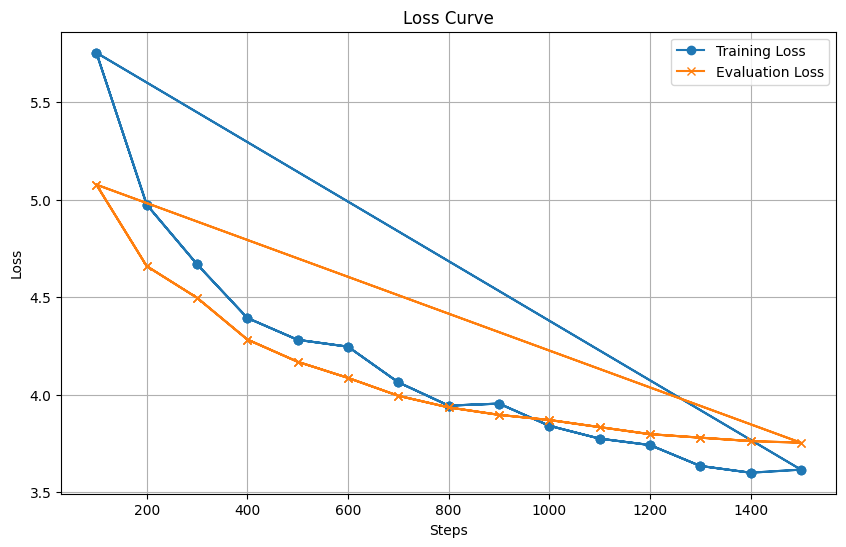

In [23]:
import matplotlib.pyplot as plt
import json
import os

# Define the paths to the training log files from checkpoints
checkpoint_dir = "/kaggle/working/checkpoint/bert_vit"
log_files = [os.path.join(checkpoint_dir, ckpt, "trainer_state.json") for ckpt in os.listdir(checkpoint_dir) if ckpt.startswith("checkpoint-")]

# Initialize lists to store loss values and steps
train_loss = []
eval_loss = []
steps = []

# Loop through each checkpoint's log file
for log_file_path in log_files:
    if os.path.exists(log_file_path):
        with open(log_file_path, 'r') as log_file:
            log_data = json.load(log_file)

            # Extract training and evaluation losses from log history
            for log in log_data.get('log_history', []):
                if 'loss' in log:
                    train_loss.append(log['loss'])
                    steps.append(log['step'])
                if 'eval_loss' in log:
                    eval_loss.append(log['eval_loss'])

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(steps[:len(train_loss)], train_loss, label="Training Loss", marker='o')
if eval_loss:
    plt.plot(steps[:len(eval_loss)], eval_loss, label="Evaluation Loss", marker='x')

plt.title("Loss Curve")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


## Examples of Model Inferencing

### Loading the Model from Checkpoint
- model.load_state_dict(...): Loads these weights into the model instance, restoring the model’s state to that of the best checkpoint.
- Path Explanation: The checkpoint is located in ../checkpoint/bert_vit/checkpoint-1500/pytorch_model.bin, where "bert_vit" identifies the multimodal model name, "checkpoint-1500" specifies the particular checkpoint, and "pytorch_model.bin" is the default file name for the saved weights.

In [24]:
import torch
import os
from safetensors import safe_open

# Assuming 'MultimodalVQAModel' is already defined
model = MultimodalVQAModel()

# Define the path to the safetensors checkpoint
checkpoint_path = os.path.join("/kaggle/working/checkpoint/bert_vit/checkpoint-1560", "model.safetensors")

# Load the model weights without specifying the device in safe_open
state_dict = {}
with safe_open(checkpoint_path, framework="pt") as f:
    state_dict = {key: f.get_tensor(key).to(device) for key in f.keys()}

# Load state_dict into the model
model.load_state_dict(state_dict)

# Move the model to the specified device
model.to(device)

MultimodalVQAModel(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

- Selects a subset of the test dataset from index 2000 to 2005 (5 samples) for inference or evaluation.
- collator(...): Passes this subset through the collator, which formats and preprocesses the batch to make it compatible with the model’s expected input format. The collator tokenizes questions and processes images, returning a dictionary of tensors.

In [25]:
sample = collator(dataset["test"][2000:2005])

input_ids = sample["input_ids"].to(device)
token_type_ids = sample["token_type_ids"].to(device)
attention_mask = sample["attention_mask"].to(device)
pixel_values = sample["pixel_values"].to(device)
labels = sample["labels"].to(device)

## Pass the Samples through the Model & inspect the Predictions

Model Inputs:
- input_ids: Token IDs of the text (questions).
- pixel_values: Image tensors.
- attention_mask: Identifies padding in the text input.
- token_type_ids: Differentiates text segments, useful for models handling paired inputs.
- labels: True labels (answers) for each sample in the batch, though labels is optional for prediction and will be used here only to compute loss.


Output:
- output is a dictionary containing "logits" (model predictions) and, if labels are provided, "loss".
- output["logits"]: Contains raw predictions (logits) for each answer class, with one row per sample in the batch and one column per class.

In [26]:
# Puts the model in evaluation mode by disabling dropout and other training-specific layers. This ensures that inference is consistent and unaffected by training variations.
model.eval()
output = model(input_ids, pixel_values, attention_mask, token_type_ids, labels)

- output["logits"].argmax(axis=-1): Finds the index of the highest logit for each sample in the batch, indicating the most probable class (predicted answer).
- .cpu().numpy(): Moves the predictions to the CPU and converts them to a NumPy array for easier handling and interpretation. The preds array now contains integer indices for the predicted classes.

In [27]:
preds = output["logits"].argmax(axis=-1).cpu().numpy()
preds

array([381, 414, 568,  76, 564])

*********************************************************


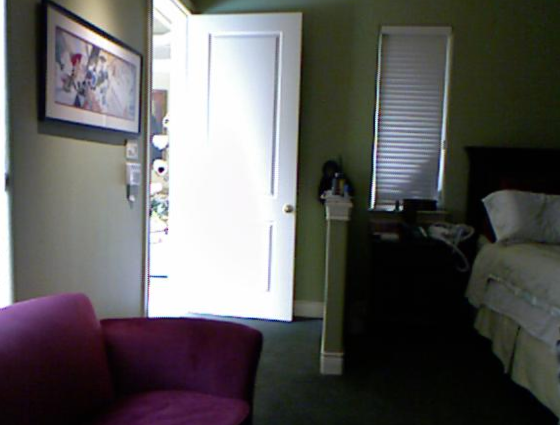

Question:	 what is on the wall
Answer:		 picture (Label: 381)
Predicted Answer:	 picture
*********************************************************
*********************************************************


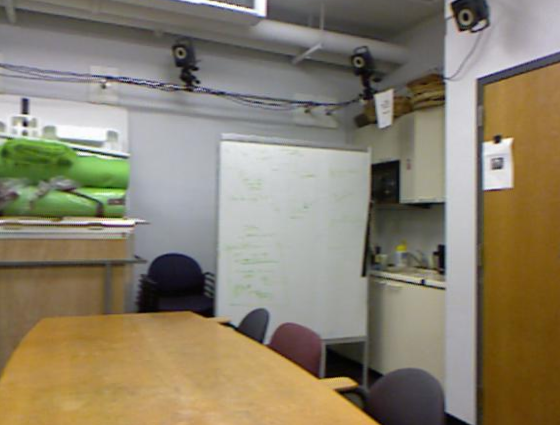

Question:	 what is the colour of the text on the whiteboard
Answer:		 green (Label: 251)
Predicted Answer:	 red
*********************************************************
*********************************************************


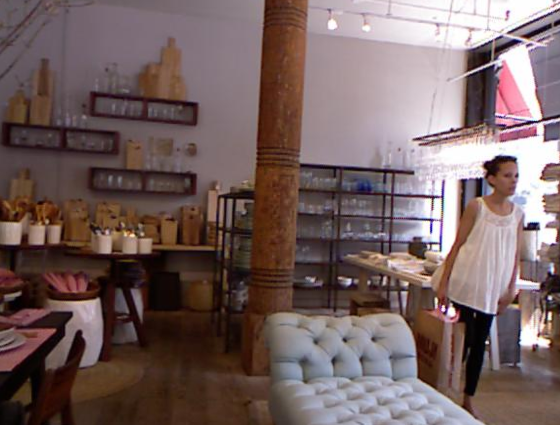

Question:	 what is behind the sofa
Answer:		 glass_ware (Label: 245)
Predicted Answer:	 window
*********************************************************
*********************************************************


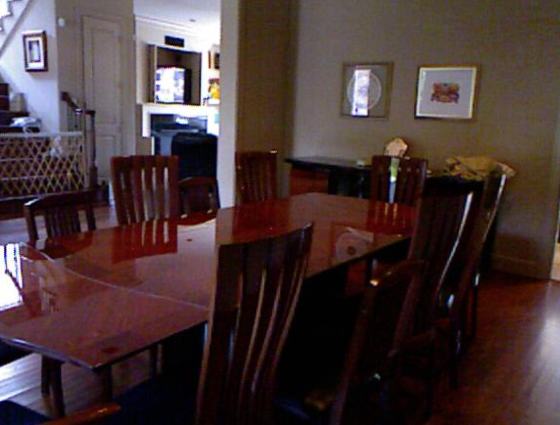

Question:	 what is the colour of the table and chair
Answer:		 brown (Label: 76)
Predicted Answer:	 brown
*********************************************************
*********************************************************


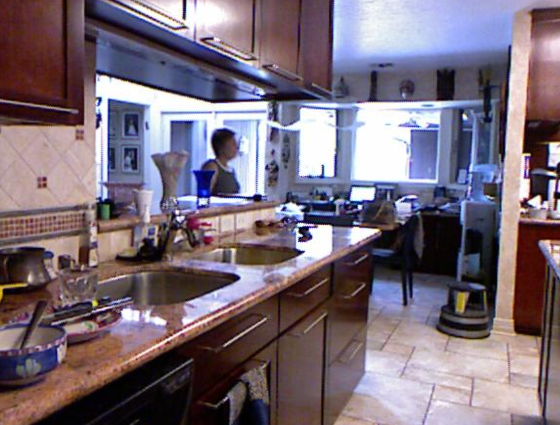

Question:	 what is the colour of the bowl
Answer:		 blue (Label: 56)
Predicted Answer:	 white
*********************************************************


In [28]:
for i in range(2000, 2005):
    print("*********************************************************")
    showExample(train=False, id=i)
    print("Predicted Answer:\t", answer_space[preds[i-2000]])
    print("*********************************************************")

## Inspecting Model Size

In [29]:
def countTrainableParameters(model):
    """
    @brief
        Calculates and prints the total number of trainable parameters in a given model.
        Trainable parameters are those with `requires_grad=True`, meaning they will be
        updated during training.

    @params
        model (torch.nn.Module): The neural network model whose trainable parameters are to be counted.

    @return
        None
    """
    
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of trainable parameters:\t{0:,}".format(num_params))

countTrainableParameters(model) # For BERT-ViT model

No. of trainable parameters:	196,956,998
